# Siamese network using binary classification


## Working mechanism

In this notebook, we will implement a Siamese network using the binary classification for pairs of hand-written digit images. Unlike the Siamese Network using the triplet loss function, we will use dataset generated by creating pairs of images. 
* If the pair of images refer to the same digit, the generated true label will be $y = 1$. 
* If the pair of images refer to two different digits, the generated true label will be $y = 0$.

We start with a classic convolution neural network that was trained beforehand. The encoding can be constructed by replacing the last layer of the network with a linear layer with the appropriate number of input features and the number of output features being equal to the encoding size. For ease of explanation, we assume that we will encode an image as a vector of size $256$, then the output of the last linear layer is $256$. When an image is passed to this network, the encoding for that image is generated. To train a Siamese neural network, two images will be passed to it to obtain two encodings. These two encodings will be combined into a bigger vector of size $2 \cdot 256 = 512$ and this resulted combined encodings will go through another linear layer $\text{Linear}[512, 1]$ and subsequently connected by a sigmoid function. The output of this Siamese neural network will be used as the probability $y = 1$ for one training example that is generated according to the rule described above. Therefore, the Siamese neural network, as described, will be trained by using binary cross entropy loss function.

**Remark**

If you don't understand the above explanation, do not panic. When you read through the code and note down how the input images are passed through the network and how the encodings are combined to produce the probability $y = 1$, you will understand the mechanism of the network better. Also, when you see how the dataset is constructed by combining pairs of images, you will get better idea how one trainining example look like and how it is supposed to go through the Siamese network. Further explanation will be provided in the corresponding section

In [15]:
# First thing first: import useful packages
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms as T
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from tqdm import tqdm

## Generate dataset

To construct trainining examples for the Siamese network described above, we combine two images pair by pair and define the true label according to each pair. If the two images in one pair refer to the same digit, the true label is $y = $. If the two images refer to two different digits, the true label is $y = 0$.

### Walk-through for understanding

Before we really define a dataset that is subclassed to `Dataset` in torch, let me walk you through the process of constructing pairs of images and the corresponding true labels. We shall try to build a dataset of $50\%$ positive examples (true label $y = 1$) and $50\%$ negative examples (true label $y = 0$). To do this, we will create one training example that is defined by an index integer number which can be even or odd. If we create $1000$ traininig examples and let the index running from $0$ to $999$, we will end up with $500$ odd number and $500$ even number. In this notebook, if the index is even, a positive trainining example is created and if the index is odd, a negative training example is created. So, we have perfect $50\%$--$50\%$ ratio in case even number of training examples is created and almost perfect $50\%$ -- $50\%$ ratio otherwise.

In [16]:
# Let us load MNIST dataset
train_mnist = datasets.MNIST('./data', train=True, download=True, transform=T.ToTensor())
valid_mnist = datasets.MNIST('./data', train=False, download=False, transform=T.ToTensor())

print(f"type(train_mnist) = {type(train_mnist)}")
print(f"type(train_mnist.data) = {type(train_mnist.data)}")
print(f"shape of the training set: {train_mnist.data.shape}")

print(f"type(train_mnist.targets) = {type(train_mnist.targets)}")
print(f"shape of the targets in th training set: {train_mnist.targets.shape}")

type(train_mnist) = <class 'torchvision.datasets.mnist.MNIST'>
type(train_mnist.data) = <class 'torch.Tensor'>
shape of the training set: torch.Size([60000, 28, 28])
type(train_mnist.targets) = <class 'torch.Tensor'>
shape of the targets in th training set: torch.Size([60000])


Before moving on, it proves useful to divide the images into $10$ groups of images, each group collects all the images for one digit. So, we have $10$ groups of images for $10$ digits. We shall denote these groups of images as $$\mathbf{G}\{j\}$ for $j = 0, \ldots, 9$. That is, we have $10$ groups 
$$
\mathbf{G}\{0\} \qquad \mathbf{G}\{1\} \qquad \cdots \qquad \mathbf{G}\{9\}.
$$

In [17]:
# Count number of times one digit appear in the database
grouped_examples = {}
targets_np = train_mnist.targets.clone().numpy()
for digit in range(0, 10):
    grouped_examples[digit] = np.where(targets_np == digit)[0]

for j in range(10):
    print(f"Number of images of digit {j}: {grouped_examples[j].shape[0]}")

Number of images of digit 0: 5923
Number of images of digit 1: 6742
Number of images of digit 2: 5958
Number of images of digit 3: 6131
Number of images of digit 4: 5842
Number of images of digit 5: 5421
Number of images of digit 6: 5918
Number of images of digit 7: 6265
Number of images of digit 8: 5851
Number of images of digit 9: 5949


In [18]:
# The dataset for the convolution neural networks in PyTorch has the shape
# (batch_size, num_channels, height, width). So, we need to unsqueeze at
# the channel dimension, that is dim = 1.
train_dataset = train_mnist.data.unsqueeze(dim=1)
valid_dataset = valid_mnist.data.unsqueeze(dim=1)

This Python function receive the index $I$ and the database of images in tensor format. First of all, a random selected class (selected digit) will be chosen. Then, we pick an image in this class. This is easily done as we have divided images into $10$ groups, each group represent one particular digit. Let us denote this selected digit as $d$ and the image for this digit $\mathrm{img}_{1}^{(I),d}$. Then, we check whether the index $I$ is even or odd. There are two scenarios.
- *If the index $I$ is even*, we need to pick another image $\mathrm{IMG}_{2}^{(I), d}$ that refers to the same digit $d$ but this image should not be the same image as $\mathrm{IMG}_{1}^{(I),d}$. Again, this is easily done by picking a random image in the group $\mathbf{G}\{d\}$ until it is not the same image as $\mathrm{IMG}_{1}^{(I),d}$. The true label for this case is $y^{(I)} = 1$.
- *If the index $I$ is odd*, we need to pick another image from a group that is different from $\mathbf{G}\{d\}$. Again, this is easily done by picking a random group in $10$ groups until it is different from $\mathbf{G}\{d\}$. This is just like picking a random integer $p$ from $0$ to $9$ so that $p \neq d$. Then, we obtain the group $\mathbf{G}\{p\}$. Then, we can pick any random image in the just selected group as $\mathrm{IMG}_{2}^{(I), p}$ with $p \neq d$. The true label for this case is $y^{(I)} = 1$.

The algorithm described in words above is explained again by Python comments in the following code. Just read through the code, it will become obvious.

In [19]:
def generate_one_sample(index, data):
    # pick some random class for the anchor image
    selected_class = np.random.randint(low=0, high=10)  # 10 is exclusive and thus 9 is inclusive
    # pick a random index for the first image in the grouped indices based on the label of the class
    rd_index_1 = np.random.randint(low=0, high=grouped_examples[selected_class].shape[0])
    # pick the index to get the first image
    index_1 = grouped_examples[selected_class][rd_index_1]
    # retrieve the first image
    image_1 = data[index_1].clone().float()

    # Now, we need to pick the seonc image. We will create the positive example if 
    # the input index is even number and the negative example if the input index is 
    # an odd number.
    if index % 2 == 0:
        rd_index_2 = np.random.randint(0, grouped_examples[selected_class].shape[0])
        while rd_index_2 == rd_index_1:
            rd_index_2 = np.random.randint(0, grouped_examples[selected_class].shape[0])
        
        # pick the index to retrieve the second image
        index_2 = grouped_examples[selected_class][rd_index_2]

        image_2 = data[index_2].clone().float()

        # set the label for this example to be positive (1)
        target = torch.tensor(1, dtype=torch.float)

    else:
        # pick a random class
        other_selected_class = np.random.randint(0, 10)
        while other_selected_class == selected_class:
            other_selected_class = np.random.randint(0, 10)

        # pick a random index for the second image in the grouped 
        # based on the label of the class
        rd_index_2 = np.random.randint(0, grouped_examples[other_selected_class].shape[0])
        index_2 = grouped_examples[other_selected_class][rd_index_2]

        image_2 = data[index_2].clone().float()

        # set the label for this example to be negative (0)
        target = torch.tensor(0, dtype=torch.float)

    return image_1, image_2, target

Let us try to test the above `generate_one_sample()`. We shall create a few training examples and visualize them.

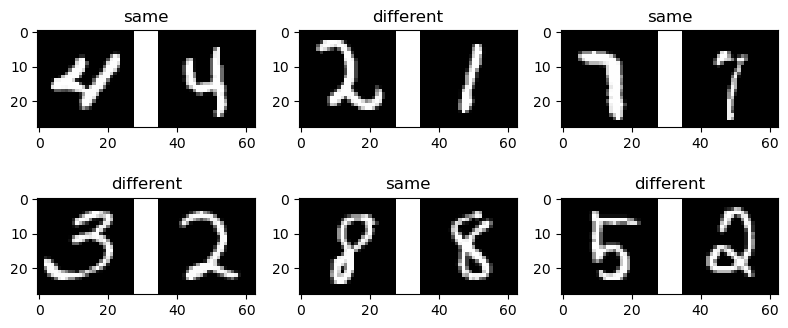

In [20]:
plt.figure(figsize=(8, 3.5))
target_txt = ['different', 'same']
nrows, ncols = 2, 3
for i, idx in enumerate(range(0, nrows*ncols)):
    
    img_1, img_2, labels = generate_one_sample(idx, train_dataset.data)

    img_1_np = img_1.squeeze().numpy()
    img_2_np = img_2.squeeze().numpy()
    white_np = 255 * np.ones((img_1_np.shape[0], img_1_np.shape[0]//4))
    ims = np.concatenate((img_1_np, white_np, img_2_np), axis=1)

    plt.subplot(nrows, ncols, i+1)
    plt.imshow(ims, cmap='gray')
    plt.title(f"{target_txt[int(labels)]}")        # convert float value target to int for indexing into target_text

plt.tight_layout()

### Put together: Create a dataset

After learning the algorithm and how to create training examples, let us put everything a class that is subclassed to `Dataset`. Writing this class involves essentially copy/paste the above code appropriately.

In [21]:
class DigitComparison(Dataset):
    def __init__(self, root, train=True, download=True):
        super(DigitComparison, self).__init__()

        # get MNIST dataset
        self.database = datasets.MNIST(root=root, train=train, download=download)

        # as `self.dataset.data`'s shape is (Nx28x28), where N is the number of
        # examples in MNIST dataset, a single example has the dimensions of
        # (28, 28) for (W, H), where W and H are the width and the height of the image. 
        # However, every example should have (C, W, H) dimensions where C is the number 
        # of channels to be passed to the network. As MNIST contains gray-scale images, 
        # we add an additional dimension to corresponds to the number of channels.
        self.images = self.database.data.unsqueeze(dim=1).clone()

        self._grouped_examples()
    def _grouped_examples(self):
        """
            To ease the accessibility of data based on the class, we will use `group_examples` to group 
            examples based on class. 
            
            Every key in `grouped_examples` corresponds to a class in MNIST dataset. For every key in 
            `grouped_examples`, every value will conform to all of the indices for the MNIST 
            dataset examples that correspond to that key.
        """

        self.grouped_examples = {}
        targets_np = self.database.targets.clone().numpy()
        for digit in range(0, 10):
            self.grouped_examples[digit] = np.where(targets_np == digit)[0]

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index):
        # pick some random class for the anchor image
        selected_class = np.random.randint(low=0, high=10)  # 10 is exclusive and thus 9 is inclusive
        # pick a random index for the first image in the grouped indices based on the label of the class
        rd_index_1 = np.random.randint(low=0, high=self.grouped_examples[selected_class].shape[0])
        # pick the index to get the first image
        index_1 = self.grouped_examples[selected_class][rd_index_1]
        # retrieve the first image
        image_1 = self.images[index_1].clone().float()

        # Now, we need to pick the seonc image. We will create the positive example if 
        # the input index is even number and the negative example if the input index is 
        # an odd number.
        if index % 2 == 0:
            rd_index_2 = np.random.randint(0, self.grouped_examples[selected_class].shape[0])
            while rd_index_2 == rd_index_1:
                rd_index_2 = np.random.randint(0, self.grouped_examples[selected_class].shape[0])
            
            # pick the index to retrieve the second image
            index_2 = self.grouped_examples[selected_class][rd_index_2]

            image_2 = self.images[index_2].clone().float()

            # set the label for this example to be positive (1)
            target = torch.tensor(1, dtype=torch.float)

        else:
            # pick a random class
            other_selected_class = np.random.randint(0, 10)
            while other_selected_class == selected_class:
                other_selected_class = np.random.randint(0, 10)

            # pick a random index for the second image in the grouped indices 
            #  based on the label of the class
            rd_index_2 = np.random.randint(0, self.grouped_examples[other_selected_class].shape[0])
            index_2 = self.grouped_examples[other_selected_class][rd_index_2]

            image_2 = self.images[index_2].clone().float()

            # set the label for this example to be negative (0)
            target = torch.tensor(0, dtype=torch.float)

        return image_1, image_2, target

### Efficient dataset

As explained in other Jupyter Notebook about Siamese Network for Asian Market, the dataset defined in this approach is clearly not efficient for accessing training/valid examples. Whenever we access an example in the dataset using `__getitem__()`, the computing process is executed for one exmaple, one by one. In this manner, if we run $50$ epochs, the process will be done $50$ times. The advantage of this approach is that the Siamese Network will be trained using different sets of training examples in each epoch because the random process in creating such training exmaples. The disadvantage is very clear: slow generation of training examples.

In the second approach, we shall generate a dataset in the constructor and keep this dataset for every trainining epoch. In this approach, whenever an example is inqueried, no computation is actually needed and the example is returned immediately.

In [ ]:
class EfficientDigitComparison(Dataset):
    def __init__(self, root, train=True, download=True):
        super(EfficientDigitComparison, self).__init__()

        # get MNIST dataset
        self.database = datasets.MNIST(root=root, train=train, download=download)

        # as `self.dataset.data`'s shape is (Nx28x28), where N is the number of
        # examples in MNIST dataset, a single example has the dimensions of
        # (28, 28) for (W, H), where W and H are the width and the height of the image. 
        # However, every example should have (C, W, H) dimensions where C is the number 
        # of channels to be passed to the network. As MNIST contains gray-scale images, 
        # we add an additional dimension to corresponds to the number of channels.
        self.images = self.database.data.unsqueeze(dim=1).clone()

        self._grouped_examples()

        n_examples, n_images_per_example = self.images.shape[0], 2
        n_channels, width, height = 1, 28, 28

        # self.data contains the example inputs. Each input is two hand-written digit images.
        # self.labels contains the true labels.
        self.data = torch.zeros(size=(n_examples, n_images_per_example, n_channels, height, width))
        self.labels = torch.zeros(size=(n_examples,))
        for idx in range(n_examples):
            # pick some random class for the anchor image
            selected_class = np.random.randint(low=0, high=10)  # 10 is exclusive and thus 9 is inclusive
            # pick a random index for the first image in the grouped indices based on the label of the class
            rd_index_1 = np.random.randint(low=0, high=self.grouped_examples[selected_class].shape[0])
            # pick the index to get the first image
            index_1 = self.grouped_examples[selected_class][rd_index_1]
            # retrieve the first image
            self.data[idx,0] = self.images[index_1].clone().float()

            # Now, we need to pick the second image. We will create the positive example if 
            # the input index is even number and the negative example if the input index is 
            # an odd number.
            if idx % 2 == 0:
                rd_index_2 = np.random.randint(0, self.grouped_examples[selected_class].shape[0])
                while rd_index_2 == rd_index_1:
                    rd_index_2 = np.random.randint(0, self.grouped_examples[selected_class].shape[0])
                
                # pick the index to retrieve the second image
                index_2 = self.grouped_examples[selected_class][rd_index_2]

                self.data[idx,1] = self.images[index_2].clone().float()

                # set the label for this example to be positive (1)
                self.labels[idx] = torch.tensor(1, dtype=torch.float32)

            else:
                # pick a random class
                other_selected_class = np.random.randint(0, 10)
                while other_selected_class == selected_class:
                    other_selected_class = np.random.randint(0, 10)

                # pick a random index for the second image in the grouped indices 
                #  based on the label of the class
                rd_index_2 = np.random.randint(0, self.grouped_examples[other_selected_class].shape[0])
                index_2 = self.grouped_examples[other_selected_class][rd_index_2]

                self.data[idx,1] = self.images[index_2].clone().float()

                # set the label for this example to be negative (0)
                self.labels[idx] = torch.tensor(0, dtype=torch.float32)

    def _grouped_examples(self):
        """
            To ease the accessibility of data based on the class, we will use `group_examples` to group 
            examples based on class. 
            
            Every key in `grouped_examples` corresponds to a class in MNIST dataset. For every key in 
            `grouped_examples`, every value will conform to all of the indices for the MNIST 
            dataset examples that correspond to that key.
        """

        self.grouped_examples = {}
        targets_np = self.database.targets.clone().numpy()
        for digit in range(0, 10):
            self.grouped_examples[digit] = np.where(targets_np == digit)[0]

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        return self.data[index,0], self.data[index,1], self.labels[index]

### Dataset and dataloader

We now create the trainining and the test dataset. The following code is idiomatic as you have read it several times in previous Jupyter Notebooks.

In [23]:
train_dataset = EfficientDigitComparison(root='./data', train=True, download=True)
test_dataset = EfficientDigitComparison(root='./data', train=False, download=True)

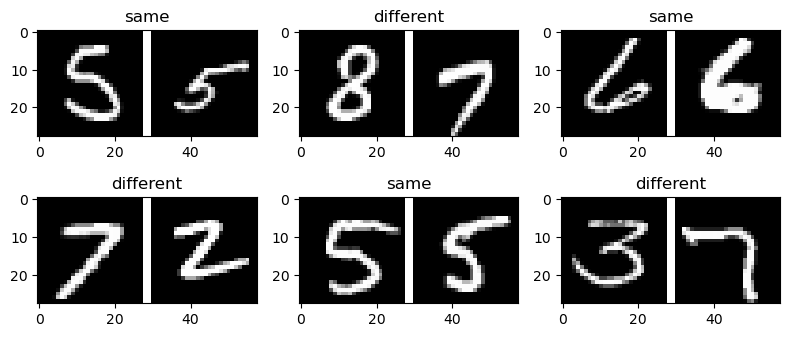

In [24]:
BATCH_SIZE = 120
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

target_txt = ['different', 'same']
plt.figure(figsize=(8, 3.5))
nrows, ncols = 2, 3
for i, idx in enumerate(range(nrows * ncols)):
    
    img_1, img_2, labels = train_dataset[idx]

    img_1_np = img_1.squeeze().numpy()
    img_2_np = img_2.squeeze().numpy()
    white_np = 255 * np.ones((img_1_np.shape[0], img_1_np.shape[0]//10))
    ims = np.concatenate((img_1_np, white_np, img_2_np), axis=1)

    plt.subplot(nrows, ncols, i+1)
    plt.imshow(ims, cmap='gray')
    plt.title(f"{target_txt[int(labels)]}")     # convert float to int for indexing into target_txt

plt.tight_layout()

## Siamense Network

### Play around ResNet-18
We shall use the classic network ResNet-18 as the basic model for building the Siamese Network. Before definining the Siamese Network, let us examine the ResNet-18 a bit.

In [25]:
resnet18 = torchvision.models.resnet18(weights=None)        # load the ResNet-18 without pretrained parameters

# As before, let us save the model architecture into a text file for reference later
model_architecture = str(resnet18)
f = open("./resnet18-architecture.txt", "w")
f.write(model_architecture)
f.close()

print(resnet18) # We can see the model architecture by the print statement.
# We can keep this model and then replace the the last layer named "classifier".
# However, I want to build a model with specific class name. So I delete the
# model here to save memory.
del resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Build Siamese Network

- As we can see, the first layer of ResNet-18 is the convolution layer with $3$ input channels and $64$ output channels with the kernel size $(7, 7)$, stride $(2, 2)$ and padding $(3, 3)$. Since the input images are gray-scale, they have only one channel. Therefore, we need to replace this convolultion layer with another convolution using only $1$ input channel. The other hyperparameters for this convolution layer will be kept unchanged. 
- As described from the beginning of this notebook, we will need to pass two images of one training example through the whole convolution neural network to obtain two encodings corresponding to these two images. Let $\mathbf{e}_1$ and $\mathbf{e}_2$ denote two such encodings.
- The two encodings $\mathbf{e}_{1}$ and $\mathbf{e}_{2}$ will be combined into a vector $\mathbf{E} = (\mathbf{e}_{1}, \mathbf{e}_{2})$ of size that is double the size of one encoding. Since one encoding is a $512$-dimensional vector, the combined encoding $\mathbf{E}$ is a $1024$-dimensional vector. 
- This $1024$-dimensional vector will be passed to the linear layer $\mathrm{Linear}[1024, 256]$, then the ReLU activation function and then mapped to a scalar by a linear layer $\mathrm{Linear}[256, 1]$. In summary, the combined encoding vector $\mathbf{E}$ needs to go through a shallow neural network defined by
$$
\mathbf{E} \mapsto \mathrm{Linear}[1024, 256] \mapsto \mathrm{ReLU} \mapsto \mathrm{Linear}[256, 1] \mapsto \mathrm{sigmoid}
$$
- The scalar output described above is then sent to the sigmoid function to represent the probability that $y = 1$ given the training example $\mathbf{x}$, denoted by $P(y = 1|\mathbf{x})$. 
- The loss function for trainining this Siamese Network is the Binary Cross Entropy Loss function.

All of these bullet points will be shown in the definition of `SiameseNetwork` class. 

**Note**  
We shall need the function `_forward_one_input(self, input)` to make the code easier to understand. It is not that necessary because the code for that function is very minimal.

In [26]:
class SiameseNetwork(nn.Module):
    """
    Siamese network for image similarity estimation.
    """
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.resnet18 = torchvision.models.resnet18(weights=None)

        # Overwrite the first conv layer to be able to read MNIST images
        self.resnet18.conv1 = nn.Conv2d(in_channels=1, out_channels=64,
                                   kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Remove the last layer of resnet18 (linear layer before average pool layer)
        self.model = torch.nn.Sequential(*list(self.resnet18.children())[:-1])

        # add linear layers to compare between the features of the two images
        self.encoding_size = self.resnet18.fc.in_features
        self.fc = nn.Sequential(nn.Linear(in_features=2*self.encoding_size, out_features=256),
                                nn.ReLU(inplace=True),
                                nn.Linear(in_features=256, out_features=1))
        
        self.sigmoid = nn.Sigmoid()

        # Initialize the weights
        self.model.apply(self._init_weights)
        self.fc.apply(self._init_weights)

    def _init_weights(self, module):
        # Initialize the weights of linear module.
        # If the module is not a Linear Module, then skip.
        if isinstance(module, nn.Linear):
            # for reference: read https://pytorch.org/docs/stable/nn.init.html
            torch.nn.init.xavier_normal_(module.weight)   
            module.bias.data.fill_(0.01)    # fill the bias with value 0.01

    def _forward_one_input(self, input):
        output = self.model(input)
        # Reshape the output to the shape (batch_size, 1) -- we have one output feature
        output = output.view(output.shape[0], -1)

        return output
    
    def forward(self, input_1, input_2):
        output_1 = self._forward_one_input(input_1)
        output_2 = self._forward_one_input(input_2)

        # Concatenate the outputs into a matrix of two columns
        output = torch.cat((output_1, output_2), dim=1)
        # Apply the signmoid function to the output.
        output = self.fc(output)

        # Note that the result is still a tensor of shape (batch_size, 2).
        # Two columns are for two inputs that go through the neural network
        # and two encodings are computed
        output = self.sigmoid(output)

        return output

## Train the Siamese Network

The following code cells need no further explanation as you are supposed to be quite familiar with the code at the point of reading this Jupyter Notebook. You should have read many more basic Notebooks uploaded on Moodle before this.

In [27]:
# Preliminary for training the model
criterion = nn.BCELoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SiameseNetwork().to(device=device)
lr = 0.0025
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [ ]:
# TRAIN THE MODEL
#===========================================
EPOCHS = 10
log_interval = 1
for epoch in range(EPOCHS):

    # Training phase
    model.train()
    for images_A, images_B, targets in tqdm(train_dataloader):

        optimizer.zero_grad()
        images_A, images_B, targets = images_A.to(device), images_B.to(device), targets.to(device)       
        outputs = model(images_A, images_B).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    if epoch % log_interval == 0:
        print(f"Epoch [{epoch} / {EPOCHS}]:")
        print(f"Train loss = {loss.item()}")

    # Test phase -- you can think of this as validation phase 
    # as we wrote code before
    model.eval()
    test_loss  = 0
    correct = 0
    with torch.no_grad():
        for images_A, images_B, targets in tqdm(test_dataloader):

            images_A, images_B, targets = images_A.to(device), images_B.to(device), targets.to(device)
            outputs = model(images_A, images_B).squeeze()
            test_loss += criterion(outputs, targets).sum().item()   # sum up batch losses
            preds = torch.where(outputs > 0.5, 1, 0) # get the index of the max log-probability
            correct += torch.sum(preds == targets.view_as(preds)).item()

    test_loss /= len(test_dataloader.dataset)
    
    if epoch % log_interval == 0:
        print(f"Test loss = {test_loss}")
        print(f"Correct = {correct}")

100%|██████████| 500/500 [13:18<00:00,  1.60s/it]


Epoch [0 / 10]:
Train loss = 0.20620299875736237


100%|██████████| 84/84 [00:16<00:00,  5.11it/s]


Test loss = 0.0017566622868180274
Correct = 9276


100%|██████████| 500/500 [08:33<00:00,  1.03s/it]


Epoch [1 / 10]:
Train loss = 0.04002540931105614


100%|██████████| 84/84 [00:16<00:00,  5.10it/s]


Test loss = 0.0006819373236037791
Correct = 9742


100%|██████████| 500/500 [08:33<00:00,  1.03s/it]


Epoch [2 / 10]:
Train loss = 0.10944326967000961


100%|██████████| 84/84 [00:16<00:00,  5.18it/s]


Test loss = 0.00041850579464808107
Correct = 9858


100%|██████████| 500/500 [08:33<00:00,  1.03s/it]


Epoch [3 / 10]:
Train loss = 0.13392779231071472


100%|██████████| 84/84 [00:16<00:00,  5.15it/s]


Test loss = 0.0004477729300269857
Correct = 9862


100%|██████████| 500/500 [08:33<00:00,  1.03s/it]


Epoch [4 / 10]:
Train loss = 0.04809509217739105


100%|██████████| 84/84 [00:16<00:00,  5.17it/s]


Test loss = 0.0003694745561806485
Correct = 9862


100%|██████████| 500/500 [08:33<00:00,  1.03s/it]


Epoch [5 / 10]:
Train loss = 0.0299207866191864


100%|██████████| 84/84 [00:16<00:00,  5.16it/s]


Test loss = 0.00031235699314856904
Correct = 9899


100%|██████████| 500/500 [08:33<00:00,  1.03s/it]


Epoch [6 / 10]:
Train loss = 0.01813872903585434


100%|██████████| 84/84 [00:16<00:00,  5.15it/s]


Test loss = 0.00033956140601076185
Correct = 9887


100%|██████████| 500/500 [08:34<00:00,  1.03s/it]


Epoch [7 / 10]:
Train loss = 0.006733533926308155


100%|██████████| 84/84 [00:16<00:00,  5.11it/s]


Test loss = 0.0003541280662524514
Correct = 9898


100%|██████████| 500/500 [08:34<00:00,  1.03s/it]


Epoch [8 / 10]:
Train loss = 0.005285387393087149


100%|██████████| 84/84 [00:16<00:00,  5.12it/s]


Test loss = 0.0003335496259591309
Correct = 9883


 67%|██████▋   | 333/500 [06:14<02:52,  1.03s/it]